In [1]:
import numpy as np
import pandas as pd

In [55]:
X_train=train_df[['Rain', 'Temperature', "GPP_500",'SoilTemp10cm', 'SoilTemp30cm', 'SoilTemp50cm']].to_numpy()
Y_train=train_df[['Soilmoisture10cm','Soilmoisture30cm', 'Soilmoisture50cm']].to_numpy()
X_test=test_df[['Rain', 'Temperature', "GPP_500", 'SoilTemp10cm', 'SoilTemp30cm', 'SoilTemp50cm']].to_numpy()
Y_test=test_df[['Soilmoisture10cm','Soilmoisture30cm', 'Soilmoisture50cm']].to_numpy()

#### SVR

In [56]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
svm_rand =MultiOutputRegressor(SVR(kernel='rbf', C=9,epsilon=0 ,gamma=0.05994842503189409))

In [57]:
#randomized search
from sklearn.model_selection import RandomizedSearchCV, KFold, GroupKFold, RepeatedKFold, GridSearchCV
from scipy.stats import randint
import time

start_time = time.time()


param_distribs_svr = {
        'estimator__kernel':['rbf'],
        'estimator__C': np.logspace(-7, 1, 100),
        'estimator__gamma': np.logspace(-4, 1, 100),
        'estimator__epsilon': np.random.uniform(low=1e-5, high=1e-1, size=10)
    }

svr_search = RandomizedSearchCV(svm_rand, param_distributions=param_distribs_svr,
                                n_iter=100, cv=RepeatedKFold(n_splits=10,n_repeats=10, random_state=42), 
                                error_score='raise', n_jobs=-1,scoring=['r2','neg_mean_absolute_error','neg_mean_squared_error'],
                                refit='neg_mean_squared_error', random_state=42)


svr_search.fit(X_train, Y_train)
end_time = time.time()
execution_time = end_time - start_time
print(f"Time taken for Randomized Search: {execution_time} seconds")

Time taken for Randomized Search: 332.2778513431549 seconds


In [58]:
svr_search.best_params_

{'estimator__kernel': 'rbf',
 'estimator__gamma': 0.1519911082952933,
 'estimator__epsilon': 0.06301977102166804,
 'estimator__C': 3.944206059437664}

In [59]:
best_params = svr_search.best_params_
best_index = svr_search.best_index_

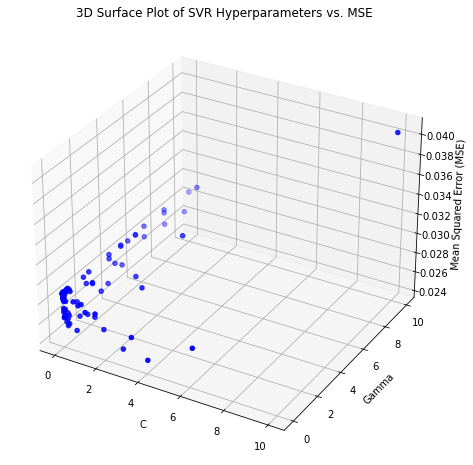

In [60]:
# Extract the results
results = svr_search.cv_results_
C_values = results['param_estimator__C'].data.astype(float)
gamma_values = results['param_estimator__gamma'].data.astype(float)
mse_scores = -results['mean_test_neg_mean_squared_error']

# Create a 3D surface plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of hyperparameter combinations and MSE scores
ax.scatter(C_values, gamma_values, mse_scores, c='blue', marker='o')

# Set axis labels
ax.set_xlabel('C')
ax.set_ylabel('Gamma')
ax.set_zlabel('Mean Squared Error (MSE)')

# Set plot title
ax.set_title('3D Surface Plot of SVR Hyperparameters vs. MSE')

plt.show()

Convergence curve

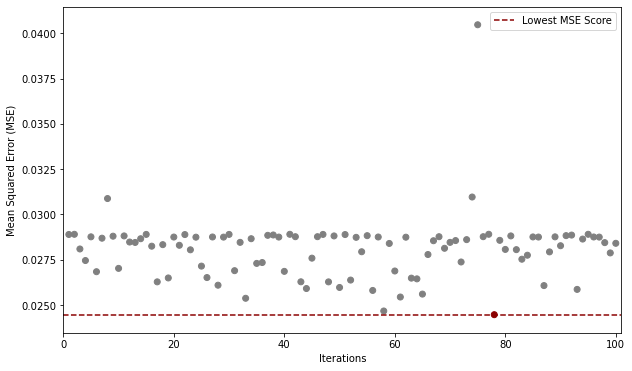

In [61]:
# Get the lowest mse_score
lowest_mse_index = np.argmin(-results['mean_test_neg_mean_squared_error'])
lowest_mse_score = mse_scores[lowest_mse_index]

# Plot convergence curves
plt.figure(figsize=(10, 6))
plt.scatter(range(1, len(results['params']) + 1),
            -results['mean_test_neg_mean_squared_error'],
            c=['darkred' if i == lowest_mse_index else 'grey' for i in range(len(results['params']))],
            marker='o')
plt.xlabel('Iterations')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('')
plt.axhline(y=lowest_mse_score, color='darkred', linestyle='--', label='Lowest MSE Score')
plt.legend()
plt.grid(False)
plt.xlim(0, len(results['params']) + 1)
plt.ylim(min(-results['mean_test_neg_mean_squared_error']-0.001), max(-results['mean_test_neg_mean_squared_error']+0.001))
plt.show()

In [62]:
### save the model
import joblib

joblib.dump(svr_search, "svr_model.pkl")

['svr_model.pkl']

In [63]:
Y_pred_test=svr_search.predict(X_test)

In [64]:
Y_predsvr10=Y_pred_test[:,0] 

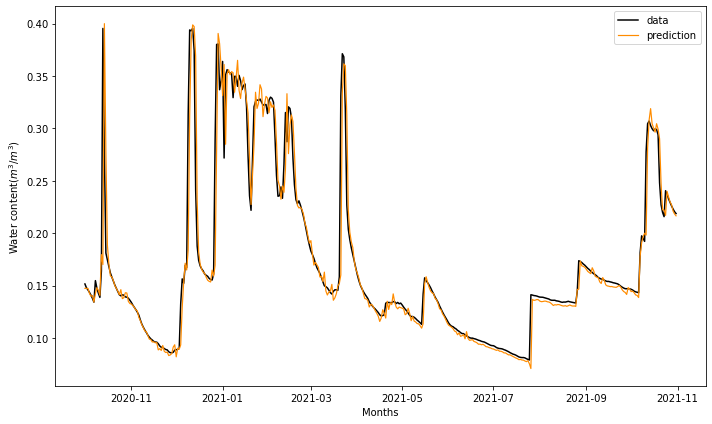

In [67]:
plt.figure(figsize=(10,6))
plt.plot(test_df.index, df_test_daily["Soilmoisture10cm"], color="black", linewidth=1.5, label="data")
plt.plot(test_df.index, Y_predsvr10, color="darkorange", linewidth=1.2, label="prediction")
plt.axis("tight")
plt.legend()
plt.xlabel("Months")
plt.ylabel("Water content($m^3/m^3$)")
plt.grid(False)
plt.tight_layout()
plt.show()  

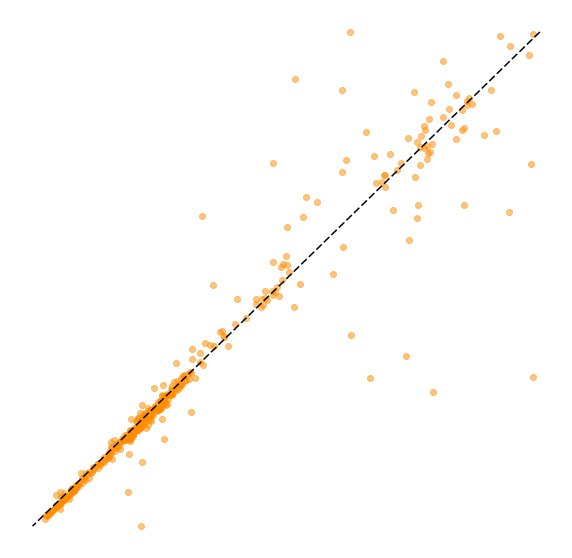

r2 score Sample 3 model is (0.9027620338886456,)


In [68]:
from sklearn.metrics import r2_score
plt.figure(figsize=(10,10)),
plt.scatter(df_test_daily["Soilmoisture10cm"], Y_predsvr10, c='darkorange', alpha=0.5),
p1 = max(max(Y_predsvr10), max(df_test_daily["Soilmoisture10cm"])),
p2 = min(min(Y_predsvr10), min(df_test_daily["Soilmoisture10cm"])),
plt.plot([p1, p2], [p1, p2], linestyle='--', dashes=(5, 2), c ='black'),
plt.grid(False)
plt.axis(False)
plt.show(),
r2 = r2_score(df_test_daily["Soilmoisture10cm"], Y_predsvr10),
print('r2 score Sample 3 model is', r2)

In [69]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(df_test_daily["Soilmoisture10cm"],Y_predsvr10)
print("The mean squared error (MSE) on test set 10cm: {:.4f}".format(mse))

The mean squared error (MSE) on test set 10cm: 0.0006


In [70]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(df_test_daily["Soilmoisture10cm"],Y_predsvr10, squared=False)
print("The root mean squared error (MSE) on test set 10cm: {:.4f}".format(mse))

The root mean squared error (MSE) on test set 10cm: 0.0246


In [71]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(df_test_daily['Soilmoisture10cm'], Y_predsvr10)   

0.0094732820997761

In [72]:
Y_predsvr30=Y_pred_test[:,1] 

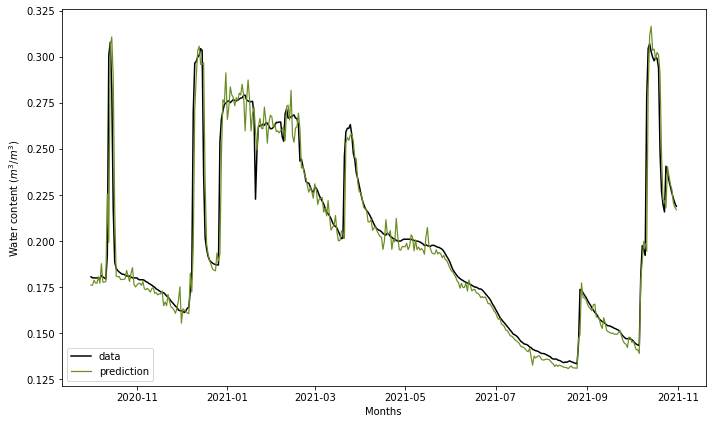

In [73]:
plt.figure(figsize=(10,6))
plt.plot(test_df.index, df_test_daily["Soilmoisture30cm"], color="black", linewidth=1.5, label="data")
plt.plot(test_df.index, Y_predsvr30, color="olivedrab", linewidth=1.2, label="prediction")
plt.axis("tight")
plt.legend()
#plt.title("SVR 30cm")
plt.xlabel("Months")
plt.ylabel("Water content ($m^3/m^3$)")
plt.grid(False)
plt.tight_layout()
plt.show()

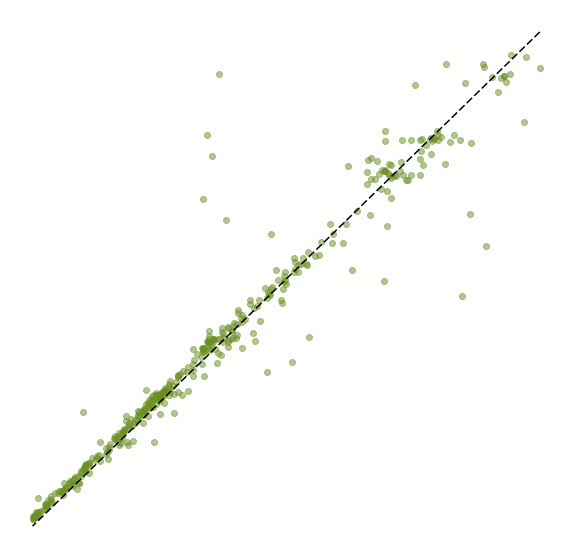

r2 score 30 cm model is (0.9343141082743774,)


In [74]:
from sklearn.metrics import r2_score
plt.figure(figsize=(10,10)),
plt.scatter(Y_predsvr30,df_test_daily["Soilmoisture30cm"], c='olivedrab', alpha=0.5),
p1 = max(max(Y_predsvr30), max(df_test_daily["Soilmoisture30cm"])),
p2 = min(min(Y_predsvr30), min(df_test_daily["Soilmoisture30cm"])),
plt.plot([p1, p2], [p1, p2], linestyle='--', dashes=(5, 2), c ='black'),
plt.grid(False)
plt.axis(False)
plt.show(),
r2 = r2_score(df_test_daily["Soilmoisture30cm"], Y_predsvr30),
print('r2 score 30 cm model is', r2)

In [75]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(df_test_daily["Soilmoisture30cm"],Y_predsvr30)
print("The mean squared error (MSE) on test set 10cm: {:.4f}".format(mse))

The mean squared error (MSE) on test set 10cm: 0.0001


In [76]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(df_test_daily["Soilmoisture30cm"],Y_predsvr30, squared=False)
print("The root mean squared error (MSE) on test set 10cm: {:.4f}".format(mse))

The root mean squared error (MSE) on test set 10cm: 0.0117


In [77]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(df_test_daily['Soilmoisture30cm'], Y_predsvr30)   

0.0053960275516003265

In [78]:
Y_predsvr50=Y_pred_test[:,2]

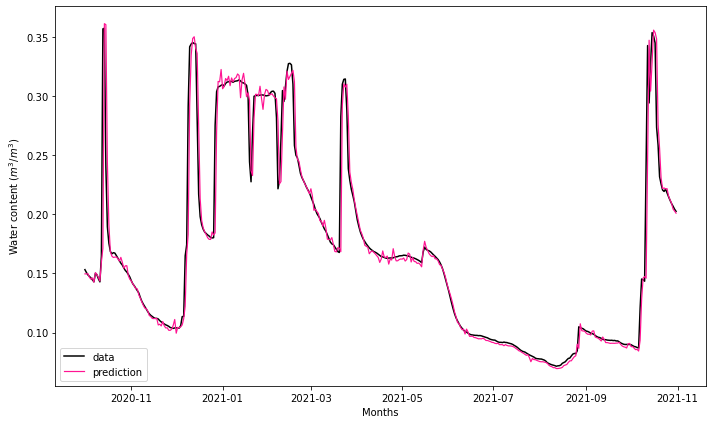

In [79]:
plt.figure(figsize=(10,6))
plt.plot(test_df.index, df_test_daily["Soilmoisture50cm"], color="black", linewidth=1.5, label="data")
plt.plot(test_df.index, Y_predsvr50, color="deeppink", linewidth=1.2, label="prediction")
plt.axis("tight")
plt.legend()
#plt.title("SVR 50cm")
plt.xlabel("Months")
plt.ylabel("Water content ($m^3/m^3$)")
plt.grid(False)
plt.tight_layout()
plt.show()

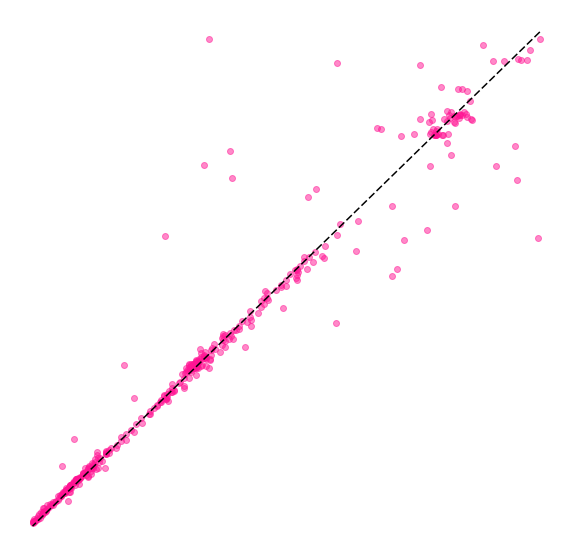

r2 score 50 cm model is (0.9405465233248743,)


In [80]:
from sklearn.metrics import r2_score
plt.figure(figsize=(10,10)),
plt.scatter(Y_predsvr50,df_test_daily["Soilmoisture50cm"], c='deeppink', alpha=0.5),
p1 = max(max(Y_predsvr50), max(df_test_daily["Soilmoisture50cm"])),
p2 = min(min(Y_predsvr50), min(df_test_daily["Soilmoisture50cm"])),
plt.plot([p1, p2], [p1, p2], linestyle='--', dashes=(5, 2), c ='black'),
plt.grid(False)
plt.axis(False)
plt.show(),
r2 = r2_score(df_test_daily["Soilmoisture50cm"], Y_predsvr50),
print('r2 score 50 cm model is', r2)

In [81]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(df_test_daily["Soilmoisture50cm"],Y_predsvr50)
print("The mean squared error (MSE) on test set 10cm: {:.4f}".format(mse))

The mean squared error (MSE) on test set 10cm: 0.0004


In [82]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(df_test_daily["Soilmoisture50cm"],Y_predsvr50, squared=False)
print("The root mean squared error (MSE) on test set 10cm: {:.4f}".format(mse))

The root mean squared error (MSE) on test set 10cm: 0.0194


In [83]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(df_test_daily['Soilmoisture50cm'], Y_predsvr50)   

0.006910486533041605

#### RF

In [84]:
np.random.seed(42)

In [85]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

rnd_clf = MultiOutputRegressor(RandomForestRegressor(n_estimators=545, max_features=6, min_samples_leaf=30,
                                                     random_state=42))
rnd_clf.fit(X_train, Y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [86]:
#grid search
from sklearn.model_selection import RandomizedSearchCV, KFold, GroupKFold, RepeatedKFold, GridSearchCV
from scipy.stats import randint
import time

start_time = time.time()


param_distribs_rf = {
        'estimator__max_features': np.arange(1,7),
        'estimator__min_samples_leaf': np.arange(10, 60, 10)
    }

rf_search = GridSearchCV(rnd_clf, param_grid=param_distribs_rf, cv=KFold(n_splits=10, shuffle=True, random_state=42), 
                                error_score='raise', n_jobs=-1,scoring=['neg_mean_squared_error'],
                                refit='neg_mean_squared_error')


rf_search.fit(X_train, Y_train)
end_time = time.time()
execution_time = end_time - start_time
print(f"Time taken for Randomized Search: {execution_time} seconds")

Time taken for Randomized Search: 379.0534930229187 seconds


In [87]:
rf_search.best_params_

{'estimator__max_features': 6, 'estimator__min_samples_leaf': 10}

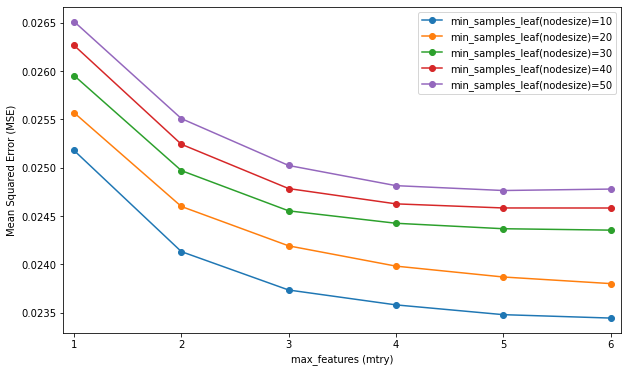

In [88]:
# Get the results from the grid search
results = rf_search.cv_results_

# Extract relevant information
max_features = np.arange(1, 7)
min_samples_leaf_values = np.arange(10, 60, 10)

# Plotting
plt.figure(figsize=(10, 6))

for min_samples_leaf in min_samples_leaf_values:
    # Filter results for a specific min_samples_leaf
    mask = results['param_estimator__min_samples_leaf'] == min_samples_leaf
    
    # Extract relevant data
    mse_scores = -results['mean_test_neg_mean_squared_error'][mask]
    
    # Plot the line
    plt.plot(max_features, mse_scores, '-o', label=f'min_samples_leaf(nodesize)={min_samples_leaf}')

plt.xlabel('max_features (mtry)')
plt.ylabel('Mean Squared Error (MSE)')
plt.xlim(0.9, 6.1)
plt.legend()
plt.grid(False)
plt.show()

In [89]:
### save the model
import joblib

joblib.dump(rf_search, "rf_model.pkl")

['rf_model.pkl']

In [90]:
Y_pred_test=rf_search.predict(X_test)

In [91]:
Y_predrf10=Y_pred_test[:,0]

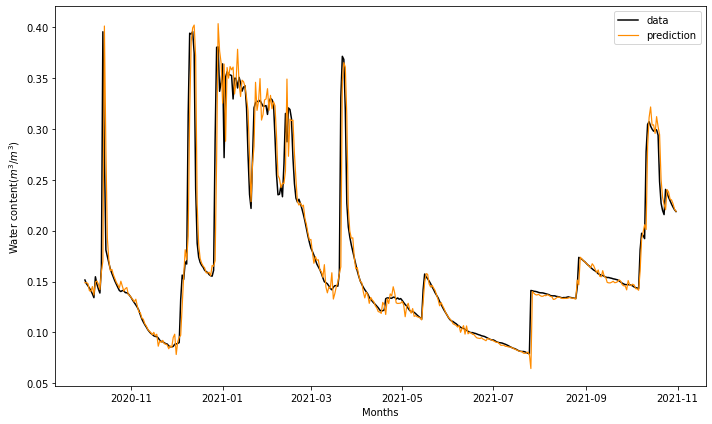

In [94]:
plt.figure(figsize=(10,6))
plt.plot(test_df.index, df_test_daily["Soilmoisture10cm"], color="black", linewidth=1.5, label="data")
plt.plot(test_df.index, Y_predrf10, color="darkorange", linewidth=1.2, label="prediction")
plt.axis("tight")
plt.legend()
#plt.title("RF 10cm")
plt.xlabel("Months")
plt.ylabel("Water content($m^3/m^3$)")
plt.grid(False)
plt.tight_layout()
plt.show()  

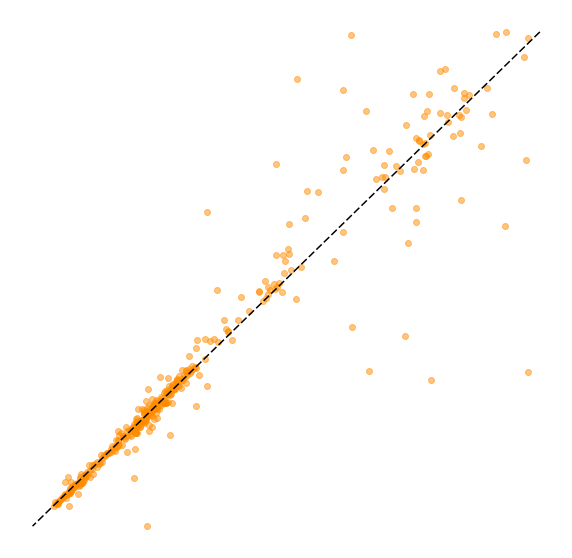

r2 score Sample 3 model is (0.9004616930746968,)


In [95]:
from sklearn.metrics import r2_score
plt.figure(figsize=(10,10)),
plt.scatter(df_test_daily["Soilmoisture10cm"], Y_predrf10, c='darkorange', alpha=0.5),
p1 = max(max(Y_predrf10), max(df_test_daily["Soilmoisture10cm"])),
p2 = min(min(Y_predrf10), min(df_test_daily["Soilmoisture10cm"])),
plt.plot([p1, p2], [p1, p2], linestyle='--', dashes=(5, 2), c ='black'),
plt.grid(False)
plt.axis(False)
plt.show(),
r2 = r2_score(df_test_daily["Soilmoisture10cm"], Y_predrf10),
print('r2 score Sample 3 model is', r2)

In [96]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(df_test_daily["Soilmoisture10cm"],Y_predrf10)
print("The mean squared error (MSE) on test set 10cm: {:.4f}".format(mse))

The mean squared error (MSE) on test set 10cm: 0.0006


In [97]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(df_test_daily["Soilmoisture10cm"],Y_predrf10, squared=False)
print("The root mean squared error (MSE) on test set 10cm: {:.4f}".format(mse))

The root mean squared error (MSE) on test set 10cm: 0.0249


In [98]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(df_test_daily['Soilmoisture10cm'], Y_predrf10)   

0.009684863973109288

In [99]:
Y_predrf30=Y_pred_test[:,1] 

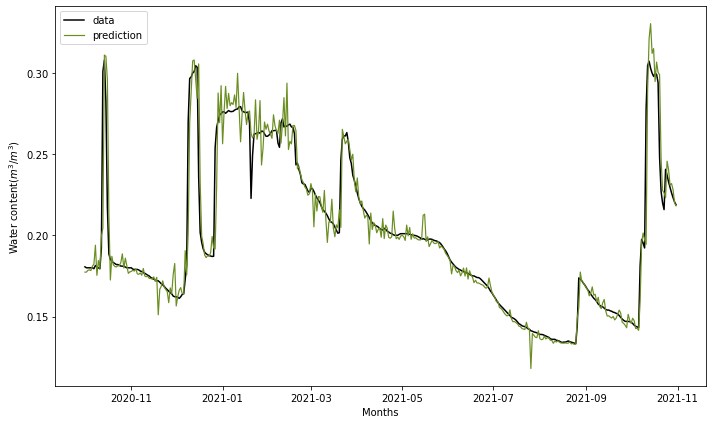

In [102]:
plt.figure(figsize=(10,6))
plt.plot(test_df.index, df_test_daily["Soilmoisture30cm"], color="black", linewidth=1.5, label="data")
plt.plot(test_df.index, Y_predrf30, color="olivedrab", linewidth=1.2, label="prediction")
plt.axis("tight")
plt.legend()
#plt.title("RF 30cm")
plt.xlabel("Months")
plt.ylabel("Water content($m^3/m^3$)")
plt.grid(False)
plt.tight_layout()
plt.show()  

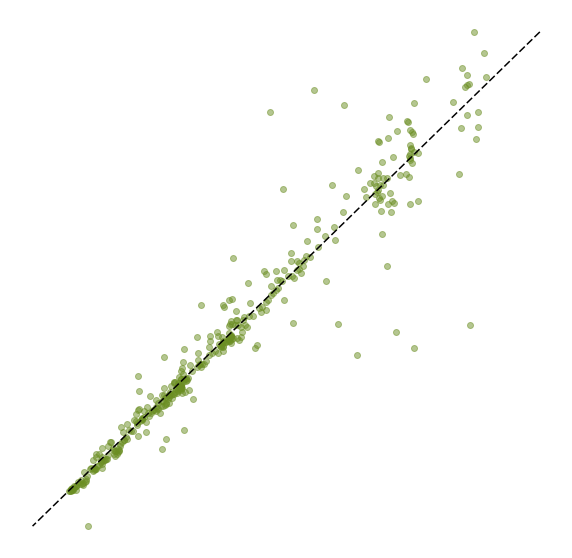

r2 score Sample 3 model is (0.9224776445756979,)


In [103]:
from sklearn.metrics import r2_score
plt.figure(figsize=(10,10)),
plt.scatter(df_test_daily["Soilmoisture30cm"], Y_predrf30, c='olivedrab', alpha=0.5),
p1 = max(max(Y_predrf30), max(df_test_daily["Soilmoisture30cm"])),
p2 = min(min(Y_predrf30), min(df_test_daily["Soilmoisture30cm"])),
plt.plot([p1, p2], [p1, p2], linestyle='--', dashes=(5, 2), c ='black'),
plt.grid(False)
plt.axis(False)
plt.show(),
r2 = r2_score(df_test_daily["Soilmoisture30cm"], Y_predrf30),
print('r2 score Sample 3 model is', r2)

In [104]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(df_test_daily["Soilmoisture30cm"],Y_predrf30)
print("The mean squared error (MSE) on test set 10cm: {:.4f}".format(mse))

The mean squared error (MSE) on test set 10cm: 0.0002


In [105]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(df_test_daily["Soilmoisture30cm"],Y_predrf30, squared=False)
print("The root mean squared error (MSE) on test set 10cm: {:.4f}".format(mse))

The root mean squared error (MSE) on test set 10cm: 0.0127


In [106]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(df_test_daily['Soilmoisture30cm'], Y_predrf30)   

0.006074713944313638

In [107]:
Y_predrf50=Y_pred_test[:,2] 

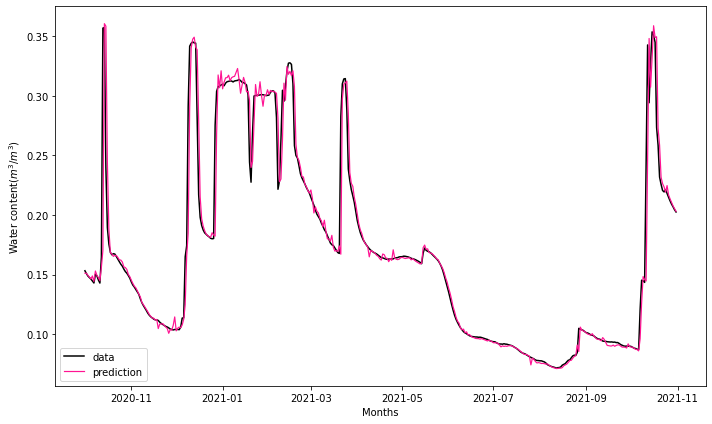

In [110]:
plt.figure(figsize=(10,6))
plt.plot(test_df.index, df_test_daily["Soilmoisture50cm"], color="black", linewidth=1.5, label="data")
plt.plot(test_df.index, Y_predrf50, color="deeppink", linewidth=1.2, label="prediction")
plt.axis("tight")
plt.legend()
#plt.title("RF 30cm")
plt.xlabel("Months")
plt.ylabel("Water content($m^3/m^3$)")
plt.grid(False)
plt.tight_layout()
plt.show()  

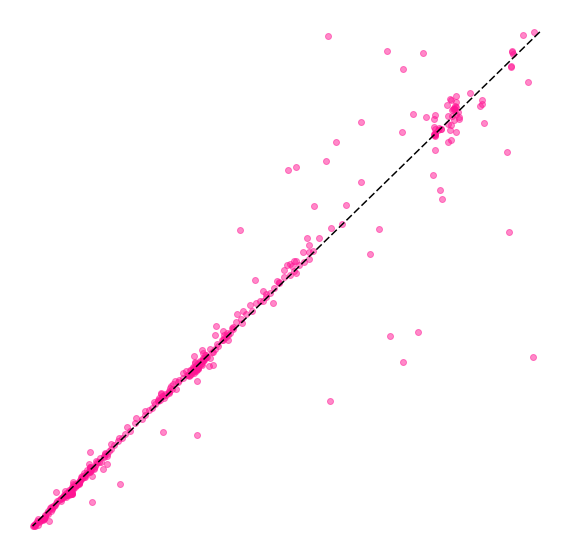

r2 score Sample 3 model is (0.9400435852322123,)


In [111]:
from sklearn.metrics import r2_score
plt.figure(figsize=(10,10)),
plt.scatter(df_test_daily["Soilmoisture50cm"], Y_predrf50, c='deeppink', alpha=0.5),
p1 = max(max(Y_predrf50), max(df_test_daily["Soilmoisture50cm"])),
p2 = min(min(Y_predrf50), min(df_test_daily["Soilmoisture50cm"])),
plt.plot([p1, p2], [p1, p2], linestyle='--', dashes=(5, 2), c ='black'),
plt.grid(False)
plt.axis(False)
plt.show(),
r2 = r2_score(df_test_daily["Soilmoisture50cm"], Y_predrf50),
print('r2 score Sample 3 model is', r2)

In [112]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(df_test_daily["Soilmoisture50cm"]/100,Y_predrf50/100)
print("The mean squared error (MSE) on test set 10cm: {:.4f}".format(mse))

The mean squared error (MSE) on test set 10cm: 0.0004


In [113]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(df_test_daily["Soilmoisture50cm"]/100,Y_predrf50/100, squared=False)
print("The root mean squared error (MSE) on test set 10cm: {:.4f}".format(mse))

The root mean squared error (MSE) on test set 10cm: 0.0194


In [114]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(df_test_daily['Soilmoisture50cm']/100, Y_predrf50/100)   

0.006570943116823748

#### Voting Regressor

In [115]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from sklearn import neighbors

rnd_clf = RandomForestRegressor(n_estimators=545, max_features=6, min_samples_leaf=10,
                                                     random_state=42)
svm_clf = SVR(kernel='rbf', C=4,gamma=0.15, epsilon=0.09)

voting_clf = MultiOutputRegressor(VotingRegressor(
    estimators=[('svr', svm_clf), ('rf', rnd_clf)], weights=[2,1]))

In [116]:
voting_clf.fit(X_train, Y_train)

MultiOutputRegressor(estimator=VotingRegressor(estimators=[('svr',
                                                            SVR(C=4,
                                                                epsilon=0.09,
                                                                gamma=0.15)),
                                                           ('rf',
                                                            RandomForestRegressor(max_features=6,
                                                                                  min_samples_leaf=10,
                                                                                  n_estimators=545,
                                                                                  random_state=42))],
                                               weights=[2, 1]))

In [117]:
### save the model
import joblib

joblib.dump(voting_clf, "voting_clf_w_svr.pkl")

['voting_clf_w_svr.pkl']

In [118]:
Y_pred_test=voting_clf.predict(X_test)

In [120]:
Y_predvr10=Y_pred_test[:,0] 

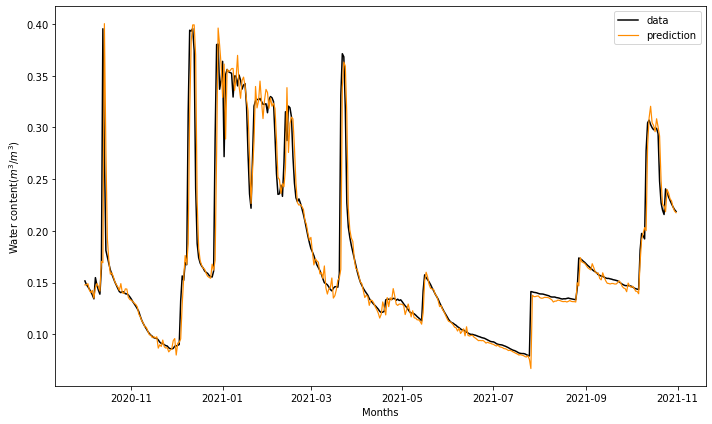

In [123]:
plt.figure(figsize=(10,6))
plt.plot(test_df.index, df_test_daily["Soilmoisture10cm"], color="black", linewidth=1.5, label="data")
plt.plot(test_df.index, Y_predvr10, color="darkorange", linewidth=1.2, label="prediction")
plt.axis("tight")
plt.legend()
#plt.title("VR 10cm")
plt.xlabel("Months")
plt.ylabel("Water content($m^3/m^3$)")
plt.grid(False)
plt.tight_layout()
plt.show()  

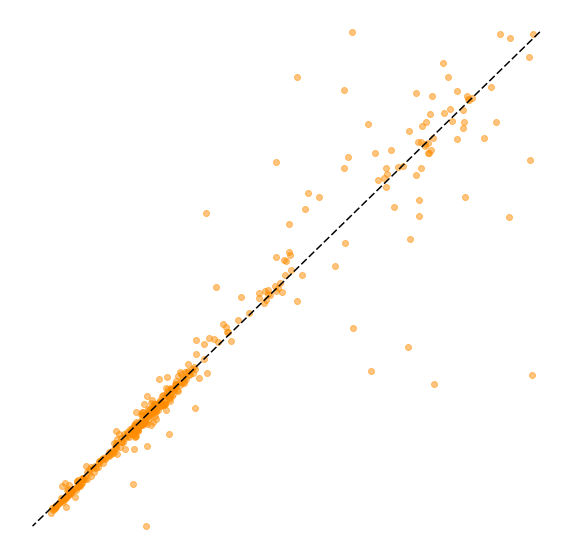

r2 score Sample 3 model is (0.9023429029355715,)


In [124]:
from sklearn.metrics import r2_score
plt.figure(figsize=(10,10)),
plt.scatter(df_test_daily["Soilmoisture10cm"], Y_predvr10, c='darkorange', alpha=0.5),
p1 = max(max(Y_predvr10), max(df_test_daily["Soilmoisture10cm"])),
p2 = min(min(Y_predvr10), min(df_test_daily["Soilmoisture10cm"])),
plt.plot([p1, p2], [p1, p2], linestyle='--', dashes=(5, 2), c ='black'),
plt.grid(False)
plt.axis(False)
plt.show(),
r2 = r2_score(df_test_daily["Soilmoisture10cm"], Y_predvr10),
print('r2 score Sample 3 model is', r2)

In [125]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(df_test_daily["Soilmoisture10cm"]/100,Y_predvr10/100)
print("The mean squared error (MSE) on test set 10cm: {:.4f}".format(mse))

The mean squared error (MSE) on test set 10cm: 0.0006


In [126]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(df_test_daily["Soilmoisture10cm"]/100,Y_predvr10/100, squared=False)
print("The root mean squared error (MSE) on test set 10cm: {:.4f}".format(mse))

The root mean squared error (MSE) on test set 10cm: 0.0247


In [127]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(df_test_daily['Soilmoisture10cm']/100, Y_predvr10/100)   

0.009623641039190977

In [128]:
Y_predvr30=Y_pred_test[:,1] 

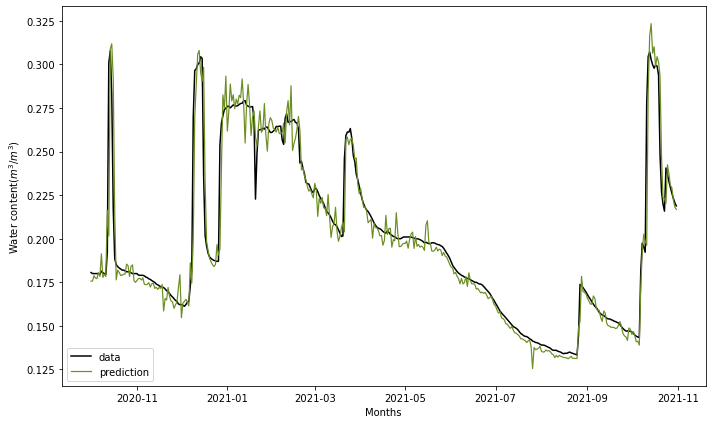

In [131]:
plt.figure(figsize=(10,6))
plt.plot(test_df.index, df_test_daily["Soilmoisture30cm"], color="black", linewidth=1.5, label="data")
plt.plot(test_df.index, Y_predvr30, color="olivedrab", linewidth=1.2, label="prediction")
plt.axis("tight")
plt.legend()
#plt.title("VR 30cm")
plt.xlabel("Months")
plt.ylabel("Water content($m^3/m^3$)")
plt.grid(False)
plt.tight_layout()
plt.show()  

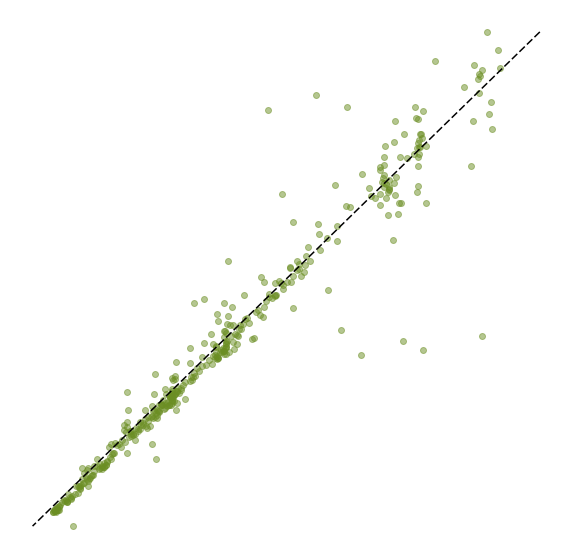

r2 score Sample 3 model is (0.930561928811559,)


In [132]:
from sklearn.metrics import r2_score
plt.figure(figsize=(10,10)),
plt.scatter(df_test_daily["Soilmoisture30cm"], Y_predvr30, c='olivedrab', alpha=0.5),
p1 = max(max(Y_predvr30), max(df_test_daily["Soilmoisture30cm"])),
p2 = min(min(Y_predvr30), min(df_test_daily["Soilmoisture30cm"])),
plt.plot([p1, p2], [p1, p2], linestyle='--', dashes=(5, 2), c ='black'),
plt.grid(False)
plt.axis(False)
plt.show(),
r2 = r2_score(df_test_daily["Soilmoisture30cm"], Y_predvr30),
print('r2 score Sample 3 model is', r2)

In [133]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(df_test_daily["Soilmoisture30cm"],Y_predvr30)
print("The mean squared error (MSE) on test set 10cm: {:.4f}".format(mse))

The mean squared error (MSE) on test set 10cm: 0.0001


In [134]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(df_test_daily["Soilmoisture30cm"],Y_predvr30, squared=False)
print("The root mean squared error (MSE) on test set 10cm: {:.4f}".format(mse))

The root mean squared error (MSE) on test set 10cm: 0.0121


In [135]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(df_test_daily['Soilmoisture30cm'], Y_predvr30)   

0.0059887756677035105

In [136]:
Y_predvr50=Y_pred_test[:,2] 

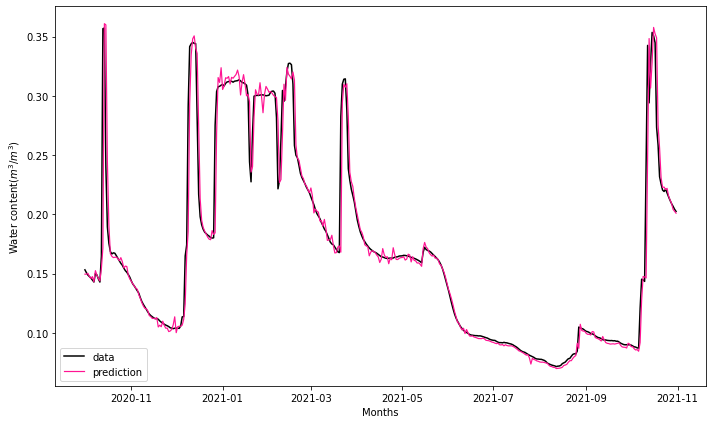

In [139]:
plt.figure(figsize=(10,6))
plt.plot(test_df.index, df_test_daily["Soilmoisture50cm"], color="black", linewidth=1.5, label="data")
plt.plot(test_df.index, Y_predvr50, color="deeppink", linewidth=1.2, label="prediction")
plt.axis("tight")
plt.legend()
#plt.title("VR 50cm")
plt.xlabel("Months")
plt.ylabel("Water content($m^3/m^3$)")
plt.grid(False)
plt.tight_layout()
plt.show()  

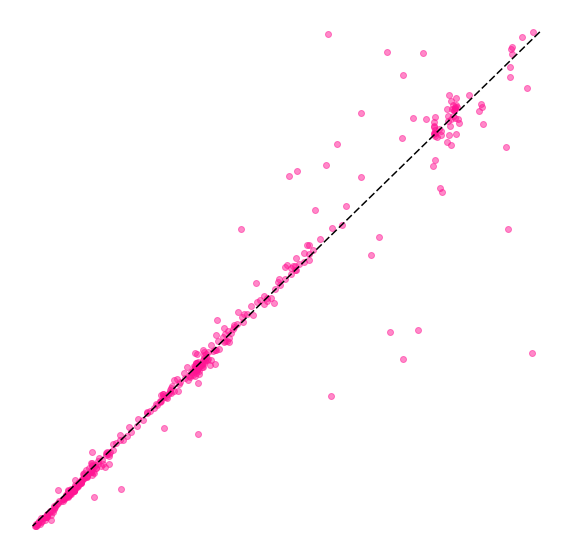

r2 score Sample 3 model is (0.940789416971562,)


In [140]:
from sklearn.metrics import r2_score
plt.figure(figsize=(10,10)),
plt.scatter(df_test_daily["Soilmoisture50cm"], Y_predvr50, c='deeppink', alpha=0.5),
p1 = max(max(Y_predvr50), max(df_test_daily["Soilmoisture50cm"])),
p2 = min(min(Y_predvr50), min(df_test_daily["Soilmoisture50cm"])),
plt.plot([p1, p2], [p1, p2], linestyle='--', dashes=(5, 2), c ='black'),
plt.grid(False)
plt.axis(False)
plt.show(),
r2 = r2_score(df_test_daily["Soilmoisture50cm"], Y_predvr50),
print('r2 score Sample 3 model is', r2)

In [141]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(df_test_daily["Soilmoisture50cm"],Y_predvr50)
print("The mean squared error (MSE) on test set 10cm: {:.4f}".format(mse))

The mean squared error (MSE) on test set 10cm: 0.0004


In [142]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(df_test_daily["Soilmoisture50cm"],Y_predvr50, squared=False)
print("The root mean squared error (MSE) on test set 10cm: {:.4f}".format(mse))

The root mean squared error (MSE) on test set 10cm: 0.0193


In [143]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(df_test_daily['Soilmoisture50cm'], Y_predvr50)   

0.006982369693080307